# Differential abundance analysis with `milopy`

**Author:** Emma Dann <br>
**Date:** 27/08/2021|

This notebook demonstrates how to run differential abundance analysis on single-cell datasets using the python implementation of the Milo framework.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo  # For mouse gastrulation data 
plt.rcParams['figure.figsize']=(8,8)
import numpy as np
import pandas as pd
sc.settings.verbosity = 3

### Load and prepare example dataset

For this vignette we will use the mouse gastrulation data from [Pijuan-Sala et al. 2019](https://www.nature.com/articles/s41586-019-0933-9). The dataset can be downloaded as a `anndata` object from the [`scvelo`](https://scvelo.readthedocs.io/scvelo.datasets.gastrulation/#scvelo.datasets.gastrulation) package (v0.2.4). 
<!-- 
I will download just a subset of samples to make the vignette faster, 6 samples at stage E7 and 6 samples at stage E7.5. -->

In [6]:
adata = scvelo.datasets.gastrulation()

In [7]:
adata

AnnData object with n_obs × n_vars = 89267 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

First, we create a Milopy object from pertpy. Next, load the adata into a MuData object.

In [8]:
milo = pt.tl.Milopy()
mdata = milo.load(adata)

In [9]:
mdata

MuData object with n_obs × n_vars = 89267 × 53801
  2 modalities
    rna:	89267 x 53801
      obs:	'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
      var:	'Accession', 'Chromosome', 'End', 'Start', 'Strand'
      obsm:	'X_pca', 'X_umap'
      layers:	'spliced', 'unspliced'
    milo_compositional:	0 x 0

We will use this dataset to identify for cell populations that increase with time (i.e. embryonic stage)

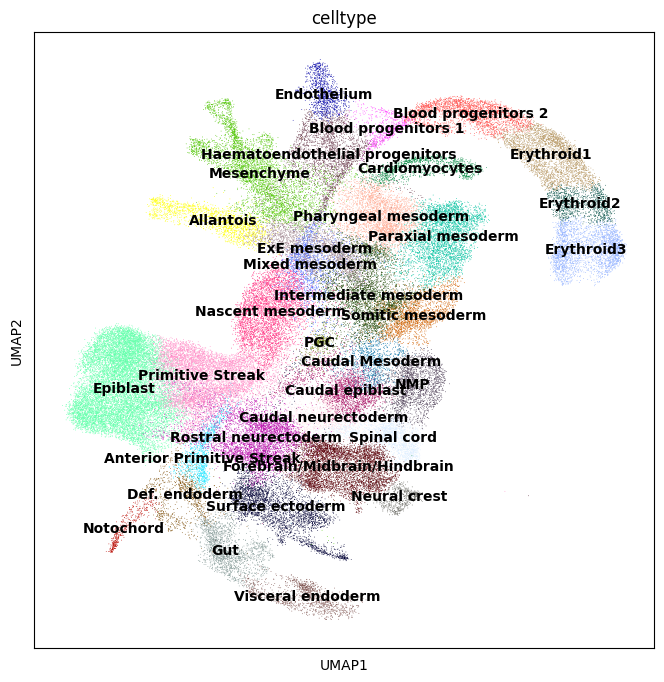

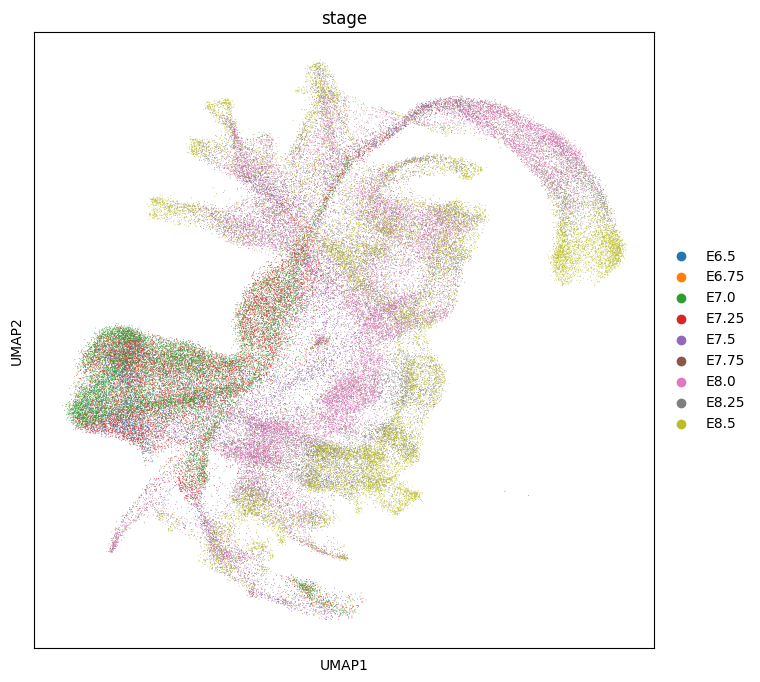

In [10]:
sc.pl.umap(mdata['rna'], color=["celltype"], legend_loc="on data");
sc.pl.umap(mdata['rna'], color=["stage"]);

### Build KNN graph

This object already contains PCA dimensionality reduction in `mdata['rna'].obsm["X_pca"]`. We can use scanpy functions to build a KNN graph. We set the dimensionality and value for k to use in subsequent steps.

In [11]:
d = 30
k = 50

sc.pp.neighbors(mdata['rna'], n_neighbors=k, n_pcs=d)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)


### Construct neighbourhoods

This step assigns cells to a set of representative neighbourhoods on the KNN graph. 

In [12]:
milo.make_nhoods(mdata['rna'], prop=0.1)

The assignment of cells to neighbourhoods is stored as a sparse binary matrix in `mdata['rna'].obsm`. Here we see that cells have been assigned to 4688 neighbourhoods.

In [13]:
mdata['rna'].obsm["nhoods"]

<89267x4688 sparse matrix of type '<class 'numpy.float32'>'
	with 607350 stored elements in Compressed Sparse Row format>

The information on which cells are sampled as index cells of representative neighbourhoods is stored in `mdata['rna'].obs`, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.

In [14]:
mdata['rna'][mdata['rna'].obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
index,,
cell_154,1,3.805366
cell_168,1,3.706167
cell_177,1,3.932041
cell_303,1,4.228216
cell_344,1,4.070614
...,...,...
cell_139180,1,4.876309
cell_139212,1,3.474515
cell_139255,1,4.865911


We can visualize the distribution of neighbourhood sizes to get an idea of the right value for k

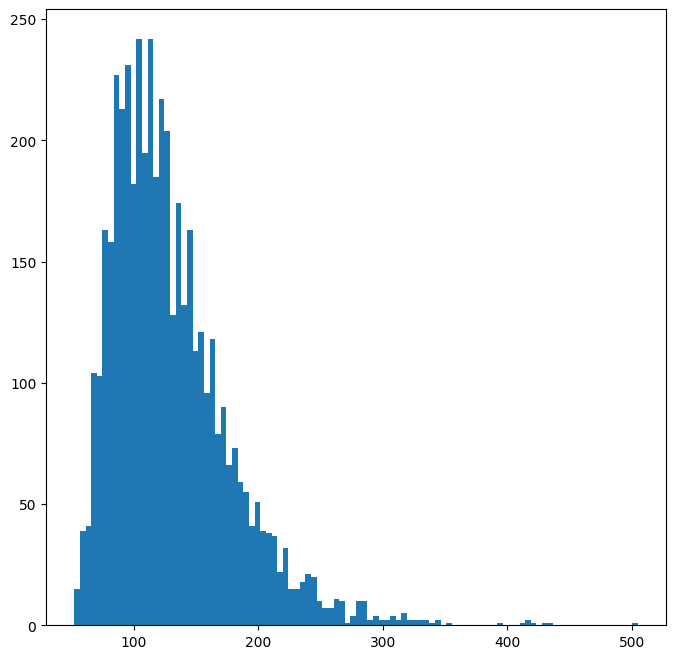

In [15]:
nhood_size = np.array(mdata['rna'].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

Since here cells come from 34 samples, we want the average number of cells in a neighbourhood to peak around 34 x 3 = 102 cells, to have a median number of 3 cells per sample per neighbourhood.

### Count cells in neighbourhoods

Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. Therefore we have to count how many cells from each sample are in each neighbourhood. We need to use the cell metadata saved in `adata.obs` and specify which column contains the sample information.

In [16]:
mdata = milo.count_nhoods(mdata, sample_col="sample")

This function adds a new modality milo_compositional to mdata. Returned mdata is a MuData with 2 modalities: rna and milo_compositional. 

mdata['milo_compositional'] is an anndata object where `obs` correspond to samples and `vars` correspond to neighbourhoods, and where `.X` stores the number of cells from each sample counted in a neighbourhood. This count matrix will be used for DA testing.

In [17]:
mdata

MuData object with n_obs × n_vars = 89267 × 53801
  2 modalities
    rna:	89267 x 53801
      obs:	'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'Accession', 'Chromosome', 'End', 'Start', 'Strand'
      uns:	'celltype_colors', 'stage_colors', 'neighbors', 'nhood_neighbors_key'
      obsm:	'X_pca', 'X_umap', 'nhoods'
      layers:	'spliced', 'unspliced'
      obsp:	'distances', 'connectivities'
    milo_compositional:	34 x 4688
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

### Differential abundance testing with GLM

We are now ready to test for differential abundance in time. The experimental design needs to be specified with R-style formulas (https://genomicsclass.github.io/book/pages/expressing_design_formula.html). In this case we need to convert the "stage" to a continuous variable, to test for linear increase over time.

In [18]:
mdata['rna'].obs["stage_continuous"] = mdata['rna'].obs["stage"].cat.codes

In [19]:
milo.da_nhoods(mdata, design="~stage_continuous")

The differential abundance test results are stored in `milo_mdata['milo_compositional'].var`. In particular:

* `logFC`: stores the log-Fold Change in abundance (i.e. the slope of the linear model)
* `PValue` stores the p-value for the test
* `SpatialFDR` stores the p-values adjusted for multiple testing (accounting for overlap between neighbourhoods)

In [20]:
mdata['milo_compositional'].var

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,cell_154,3.805366,-1.429488,8.566519,144.083856,1.001325e-14,9.779603e-14,1.024959e-13
1,cell_168,3.706167,-0.840398,8.090320,29.839121,2.153194e-06,3.675955e-06,3.636118e-06
2,cell_177,3.932041,-1.649935,8.982710,199.593507,2.471742e-16,1.016450e-14,1.087183e-14
3,cell_303,4.228216,-0.804121,7.957636,16.990275,1.665796e-04,2.254403e-04,2.214136e-04
4,cell_344,4.070614,-1.187720,8.554787,79.583635,2.289996e-11,8.520240e-11,8.891677e-11
...,...,...,...,...,...,...,...,...
4683,cell_139180,4.876309,1.565240,8.791596,161.273637,4.120109e-14,2.971549e-13,3.108495e-13
4684,cell_139212,3.474515,1.709693,9.168870,231.242758,3.053558e-10,9.428796e-10,9.770431e-10
4685,cell_139255,4.865911,1.567425,8.752766,195.502470,3.958532e-13,2.067495e-12,2.163515e-12
4686,cell_139261,5.644740,1.178933,8.357718,69.602088,1.468193e-10,4.759951e-10,4.953902e-10


We can start inspecting the results of our DA analysis from a couple of standard diagnostic plots. 

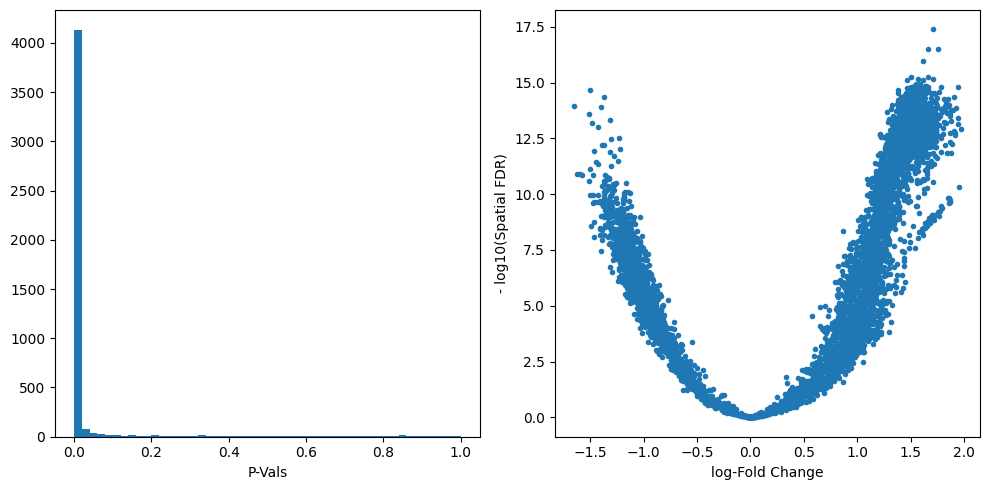

In [21]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(mdata['milo_compositional'].var.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(mdata['milo_compositional'].var.logFC, -np.log10(mdata['milo_compositional'].var.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

### Visualize results on embedding

To visualize DA results relating them to the embedding of single cells, we can build an abstracted graph of neighbourhoods that we can superimpose on the single-cell embedding. Here each node represents a neighbourhood, while edges indicate how many cells two neighbourhoods have in common. Here the layout of nodes is determined by the position of the index cell in the UMAP embedding of all single-cells. The neighbourhoods displaying singificant DA are colored by their log-Fold Change.

In [22]:
milo.build_nhood_graph(mdata)

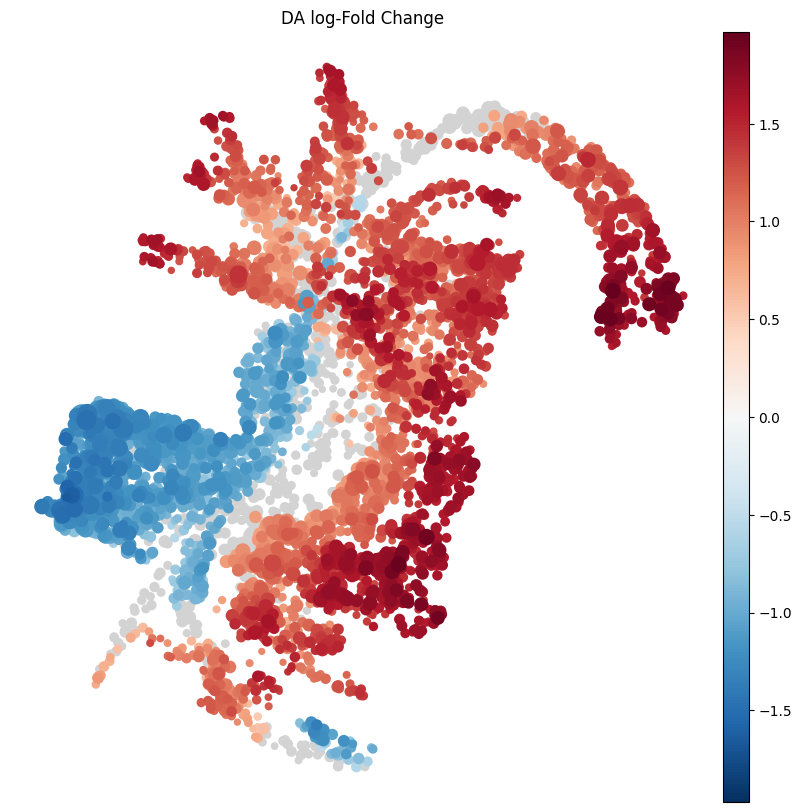

In [23]:
plt.rcParams["figure.figsize"] = [10,10]
pt.pl.milo.nhood_graph(mdata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=2 ## Size of smallest dot
                       )

### Visualize result by celltype

We might want to visualize whether DA is particularly evident in certain cell types. To do this, we assign a cell type label to each neighbourhood by finding the most abundant cell type within cells in each neighbourhood (after all, neighbourhoods are in most cases small subpopulations within the same cell type). We can label neighbourhoods in the results data.frame using the function `milo.annotate_nhoods`. This also saves the fraction of cells harbouring the label.

In [24]:
milo.annotate_nhoods(mdata, anno_col='celltype')

We can see that for the majority of neighbourhoods, almost all cells have the same neighbourhood. We can rename neighbourhoods where less than 60% of the cells have the top label as "Mixed"

Text(0.5, 0, 'celltype fraction')

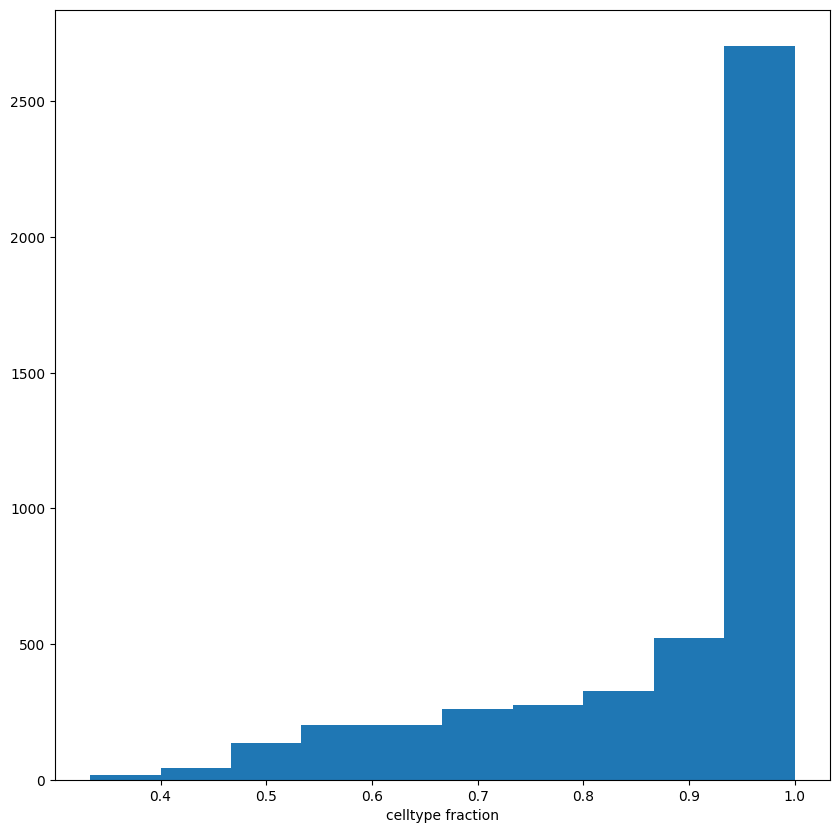

In [25]:
plt.hist(mdata['milo_compositional'].var["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

In [26]:
mdata['milo_compositional'].var.loc[mdata['milo_compositional'].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

Now we can plot the fold changes using da_beeswarm function from Milopy

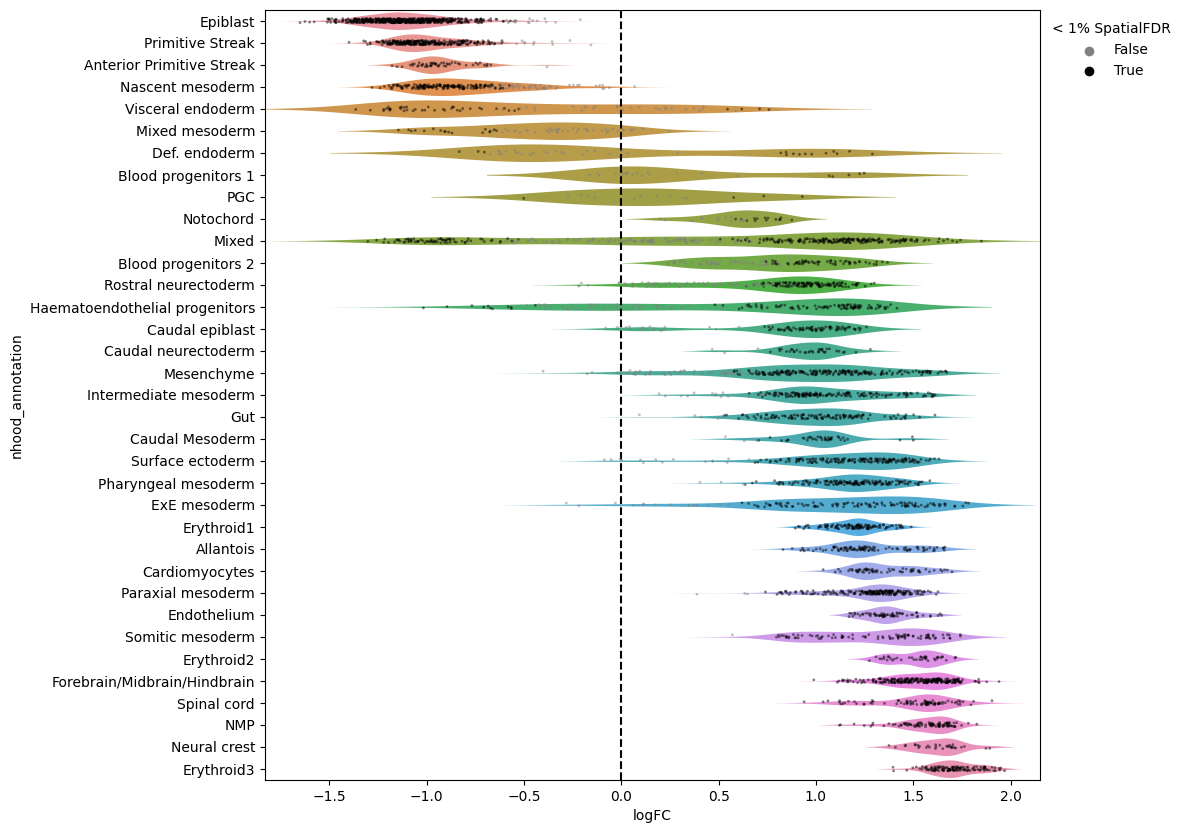

In [43]:
pt.pl.milo.da_beeswarm(mdata, alpha=0.01)

Here this shows that neighbourhoods of cells of the epiblast and primitive streak are enriched in early stages and cells from the neural crest are enriched in later stages.